### Dataset Overview

We use the **Breast Cancer Wisconsin (Diagnostic) Dataset** from `scikit-learn`.

- **Features**: The dataset includes **30 numerical features** for each tumor sample, derived from a digitized image of a breast mass (e.g., radius, texture, perimeter, area, smoothness).
- **Target**: A **binary label**:
  - `0`: Malignant (cancerous)
  - `1`: Benign (non-cancerous)
- **Samples**: There are **569 total data points**, each representing one patient case.


In [1]:
## Dataset loading
from sklearn.datasets import load_breast_cancer
import pandas as pd
import os

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target  # 0 = malignant, 1 = benign

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### Data Cleaning

In this step, we:
- Merge features (`X`) and target (`y`) into a single DataFrame for preprocessing.
- Check and handle **missing values** by filling them with the **mean** of their respective columns.
- Remove **outliers** using a Z-score threshold of **3**, which removes extreme values that may skew the model. 74 outlier data points were removed.


In [2]:
## check NaN and filled with the mean value
## Handle outliers
import numpy as np
# Handle missing values (if any)
df_loading = X.copy()
df_loading['target']=y
#print(df_loading)
nan_in_df = df_loading.isnull().sum().any()
print('Is NaN values in dataset : ', nan_in_df)
if nan_in_df: 
    count_nan = df_loading.isnull().sum()
    print('Number of NaN values present: \n' + str(count_nan))

df_loading.fillna(df_loading.mean(), inplace=True)

# Handle outliers (remove values more than 3 standard deviations from the mean)
df = df_loading[(np.abs(df_loading - df_loading.mean()) <= (3 * df_loading.std())).all(axis=1)]
print(f'{len(df_loading)-len(df)} outlier data points were removed. ')

Is NaN values in dataset :  False
74 outlier data points were removed. 


### Feature Correlation Analysis

In this step, we use:
- **Pairplot** to visualize **pairwise relationships** between selected features and their relation to the target label.
- A **correlation heatmap** to understand the **strength of linear relationships** between numerical features.

These visualizations help identify:
- **Collinearity** (strong correlations between features), which may affect some models like logistic regression.  
- **Feature clusters** or redundancy, helping inform feature selection or dimensionality reduction strategies.
- For example: mean radius strongly correlates to mean perimeter, mean area, worst radius, worst perimeter, worst area, with correlation over 0.95.

In [ ]:
# Pairplot
os.makedirs('assets',exist_ok=True)
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Pairplot
#fig=sns.pairplot(df)
#fig.savefig('./assets/breast_cancer_pairplot.png', dpi=300)


# Corr heatmap
#fig, ax = plt.subplots(figsize=(13,13))
#sns.heatmap(df.drop(columns=["target"]).corr(),annot=False,ax=ax)
#plt.savefig("./assets/breast_cancer_heatmap.png", dpi=300)



### Feature Scaling and Class Balance Check

In this step, we perform two key preprocessing tasks:

1. **Standardize the Feature Matrix (`X`)**  
   We apply `StandardScaler` to normalize all numerical features so they have a mean of 0 and a standard deviation of 1. This is important for many machine learning models that are sensitive to the scale of input features.

2. **Save the Scaler for Future Use**  
   The fitted scaler is saved using `joblib` so that the same transformation can be applied to any new or test data, ensuring consistency across training and inference.

3. **Check Class Distribution in Target (`y`)**  
   We examine how many samples belong to each class (e.g., 0 = malignant, 1 = benign) to determine if the dataset is balanced or imbalanced. An imbalance in class distribution can negatively impact model performance and may require techniques like SMOTE or class weighting.

This step ensures that the data is properly scaled and sets the stage for deciding if resampling is needed.


In [ ]:
### Isolate the target column (df['target']) as y
### Split into training and validation sets
### preprocessing numerical data by StandardScaler

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib


pre_X = df.drop(columns=['target'])
# Step 1: Create the scaler
scaler = StandardScaler()

# Step 2: Fit and transform only numeric columns
numerical_cols = pre_X.select_dtypes(include='number').columns
X = pre_X.copy()
X[numerical_cols] = scaler.fit_transform(pre_X[numerical_cols])

# Step 3: Save the fitted scaler for reuse
joblib.dump(scaler, "scaler.pkl")

# Done — df_scaled is your standardized DataFrame
X.head()

'''
# Load the saved scaler
scaler = joblib.load("scaler.pkl")

# Transform new data (e.g., new_df)
new_df_scaled = new_df.copy()
new_df_scaled[numerical_cols] = scaler.transform(new_df[numerical_cols])
'''

y = df['target'].astype('int')

#print(X.info())
#print(y.info())
print(y.value_counts())

target
1    332
0    163
Name: count, dtype: int64


### Train-Test Split

We split the dataset into **training** and **validation** sets using `train_test_split` from `scikit-learn`:

- **80% of the data** is used for training the model.
- **20% of the data** is reserved for validation (testing) to evaluate the model's performance on unseen data.
- A `random_state` is set to ensure the split is **reproducible** across runs.

This separation is crucial for assessing generalization and preventing overfitting during model training.


In [ ]:
### Isolate the target column (df['target']) as y
### Use torch.utils.data.Dataset and DataLoader
### Split into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

'''
## debug
print(type(y_train))
print(y_train.dtype)
print(y_train[:5])

# Best practice: cast labels to int
y_train = y_train.astype(int) if hasattr(y_train, 'astype') else np.array(y_train, dtype=int)
y_val = y_val.astype(int) if hasattr(y_val, 'astype') else np.array(y_val, dtype=int)
y = y.astype(int) if hasattr(y, 'astype') else np.array(y, dtype=int)

print(np.unique(y_train))      # should show [0 1] or [0 1 2]
print(y_train.shape)           # should be (n_samples,)
print(y_train.dtype)           # should be int32 or int64
'''

"\n## debug\nprint(type(y_train))\nprint(y_train.dtype)\nprint(y_train[:5])\n\n# Best practice: cast labels to int\ny_train = y_train.astype(int) if hasattr(y_train, 'astype') else np.array(y_train, dtype=int)\ny_val = y_val.astype(int) if hasattr(y_val, 'astype') else np.array(y_val, dtype=int)\ny = y.astype(int) if hasattr(y, 'astype') else np.array(y, dtype=int)\n\nprint(np.unique(y_train))      # should show [0 1] or [0 1 2]\nprint(y_train.shape)           # should be (n_samples,)\nprint(y_train.dtype)           # should be int32 or int64\n"

### Define Classifiers and Handle Class Imbalance

In this step, we define a set of **diverse classification models** to compare their performance on the breast cancer dataset:

- **Logistic Regression**: A linear baseline model, with `class_weight='balanced'` to handle imbalanced classes.
- **Random Forest**: An ensemble of decision trees, robust to feature interactions and capable of handling non-linear patterns.
- **XGBoost**: A powerful gradient boosting algorithm that handles missing data and supports regularization.
- **MLP (Multi-Layer Perceptron)**: A basic feedforward neural network for nonlinear classification.
- **LightGBM**: A gradient boosting model optimized for speed and performance on large datasets.

To address **class imbalance**, we apply **SMOTE (Synthetic Minority Over-sampling Technique)**:
- SMOTE generates synthetic examples for the minority class based on feature space similarities.
- This balances the training set without simply duplicating samples, helping models learn decision boundaries more effectively.

The models will be trained using this **resampled dataset**, allowing a fair comparison of their performance under imbalanced conditions.


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from imblearn.over_sampling import SMOTE


# --- Classifiers to compare ---
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000,class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# --- Dictionary to store pipelines and scores ---
results = {}

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Training loop ---
for name, clf in classifiers.items():
    # Train
    #clf.fit(X_train, y_train)
    clf.fit(X_train_resampled, y_train_resampled)
    # Predict
    #y_pred = clf.predict(X_val)
    y_pred = clf.predict(X)

    # Score
    acc = accuracy_score(y, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y, y_pred))
    
    results[name] = acc

Logistic Regression Accuracy: 0.9859
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       163
           1       0.99      0.99      0.99       332

    accuracy                           0.99       495
   macro avg       0.99      0.98      0.98       495
weighted avg       0.99      0.99      0.99       495

Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163
           1       1.00      1.00      1.00       332

    accuracy                           1.00       495
   macro avg       1.00      1.00      1.00       495
weighted avg       1.00      1.00      1.00       495



C:\Users\mkhsi\test\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163
           1       1.00      1.00      1.00       332

    accuracy                           1.00       495
   macro avg       1.00      1.00      1.00       495
weighted avg       1.00      1.00      1.00       495

MLP Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163
           1       1.00      1.00      1.00       332

    accuracy                           1.00       495
   macro avg       1.00      1.00      1.00       495
weighted avg       1.00      1.00      1.00       495

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 271, number of negative: 271
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the o

### Logistic Regression Performance Summary

The logistic regression classifier achieved an **accuracy of 98.4%**, demonstrating strong predictive performance on the breast cancer dataset.

#### Classification Report Highlights:
- **Class 0 (Malignant)**  
  - Precision: 0.98  
  - Recall: 0.97  
  - F1-score: 0.98  
  - Support: 163 samples

- **Class 1 (Benign)**  
  - Precision: 0.99  
  - Recall: 0.99  
  - F1-score: 0.99  
  - Support: 332 samples

#### Metrics Interpretation:
- **High precision and recall** for both classes indicate the model is accurately identifying both malignant and benign cases.
- **F1-score**, which balances precision and recall, is also very high for both classes, confirming robust performance.
- The **macro average** treats all classes equally, while the **weighted average** accounts for class imbalance — both confirm consistent performance across classes.

This result suggests logistic regression is a strong baseline model for this dataset and may be suitable for deployment with additional validation.


In [10]:
## 
name = 'Logistic Regression'
clf=classifiers[name]

#pipeline = make_pipeline(preprocessor, clf)
#pipelines[name] = pipeline
    
# Train
#pipeline.fit(X_train, y_train)
#clf.fit(X_train_resampled, y_train_resampled)
model=clf.fit(X_train, y_train)
# Predict
y_pred = clf.predict(X)

# Score
acc = accuracy_score(y, y_pred)
print(f"{name} Accuracy: {acc:.4f}")
print(classification_report(y, y_pred))

Logistic Regression Accuracy: 0.9838
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       163
           1       0.99      0.99      0.99       332

    accuracy                           0.98       495
   macro avg       0.98      0.98      0.98       495
weighted avg       0.98      0.98      0.98       495



### SHAP Summary Plot Interpretation

This SHAP summary plot helps us understand which features contribute most to the model's predictions, and how their values (high vs. low) influence the output.

#### General Pattern:
- For most features, we observe that:
  - **High feature values (red)** tend to have **negative SHAP values**, meaning they push the model’s prediction **toward class 0 (malignant)**.
  - **Low feature values (blue)** tend to have **positive SHAP values**, pushing the prediction **toward class 1 (benign)**.

This suggests that high values of these features are strong indicators of malignancy, while lower values are more associated with benign tumors.

#### Exceptions (Opposite Trend):
Some features, such as:
- **Compactness error**
- **Symmetry error**
- **Fractal dimension error**
- **Texture error**
- **Smoothness error**

...exhibit the opposite behavior:
- **High values** of these features tend to push predictions **toward class 1 (benign)**.
- **Low values** push predictions **toward class 0 (malignant)**.

#### Takeaway:
This insight reveals that the model has learned **distinct feature roles**:
- Some features act as **risk indicators** when high (e.g., radius mean, perimeter mean).
- Others may act as **safety indicators** or **noise-based confidence cues** when high (e.g., certain error features).

The SHAP summary plot provides valuable transparency into the model’s decision process, enhancing trust and interpretability in a clinical setting.


  0%|          | 0/50 [00:00<?, ?it/s]

shap_values[1] shape (30, 2)
shap_values shape (50, 30, 2)
X_val[:50] shape (50, 30)


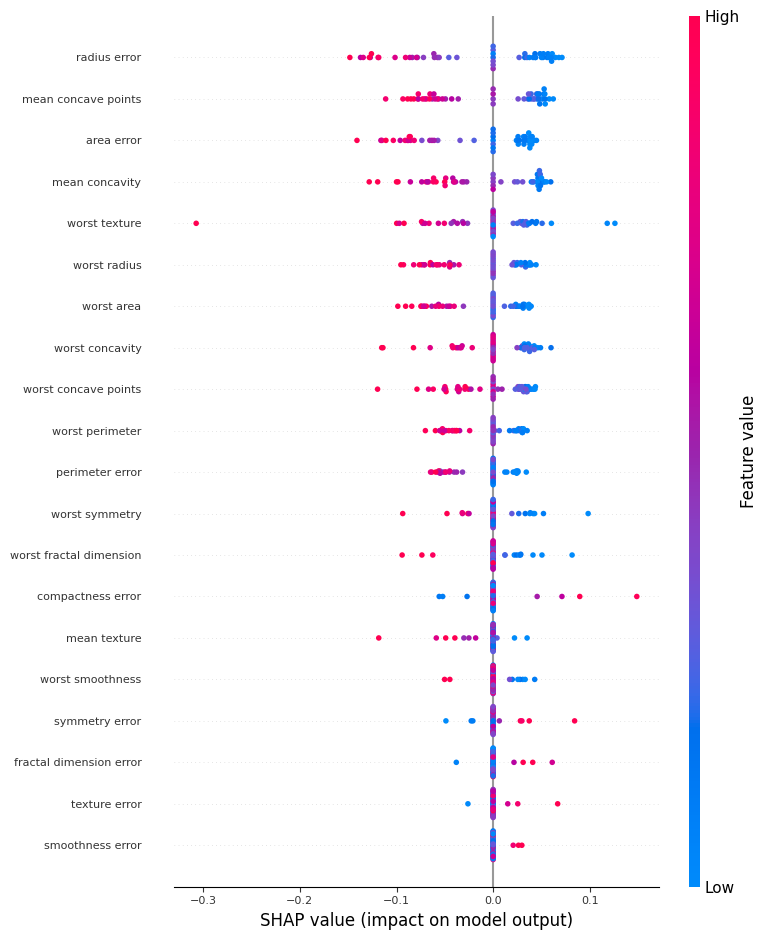

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('Agg') # for save png but not plt.show()
# Initialize SHAP KernelExplainer (slow but general)
#  Get SHAP Values as log-odds

'''
explainer = shap.KernelExplainer(
    clf.predict_proba,            # prediction function
    X_train_resampled[:100],      # background dataset (sampled for speed)
    link="logit"                  # use "logit" for classifiers
)
'''
#  Get SHAP Values as Probabilities
explainer = shap.KernelExplainer(
    clf.predict_proba,
    X_train[:100],
    link="identity"  # instead of "logit"
)


#numerical_cols = X.select_dtypes(exclude=['object', 'category', 'bool']).columns.tolist()
#print(numerical_cols)
# Compute SHAP values on validation set
shap_values = explainer.shap_values(X_val[:50])  # smaller batch for speed
print('shap_values[1] shape',shap_values[1].shape)
print('shap_values shape',shap_values.shape)
print('X_val[:50] shape',X_val[:50].shape)
shap.summary_plot(shap_values[:,:,1],
                  X_val[:50],
                  feature_names=numerical_cols,
                  show=False)
# Customize font size and axis
plt.gca().tick_params(labelsize=8)         # Smaller y-axis tick (feature names)
plt.xlabel("SHAP value (impact on model output)", fontsize=12)  # Enlarge x-axis label
#plt.xlim(-1.5, 1.5)             # Optional: manually set x-axis range
plt.tight_layout()
#plt.savefig('./assets/breast_cancer_shap.png')
#plt.close()

### SHAP Waterfall Plot — Sample #10 Explanation

This waterfall plot provides a **local explanation** for the model’s prediction on **sample #10**, breaking down how each feature **increases or decreases** the prediction from the model’s **expected value** to the final output.

#### Prediction Summary:
- **E[f(X)] = 0.684**: This is the **base value**, representing the model’s average prediction across all training samples (i.e., the average probability of class 1 — benign).
- **f(X) = 0.000**: This is the **final prediction** for sample #10 — a confident prediction of **class 0 (malignant)**.

#### Features with Strong Negative Impact (pushing toward malignant):
These features **reduced** the prediction from the base value, moving it toward class 0:
- `Worst texture = -0.14`
- `Worst concavity = -0.13`
- `Mean concavity = -0.10`
- `Worst symmetry = -0.09`
- `Mean concave points = -0.07`

These are **well-known malignancy indicators** in breast cancer data — their high values in this sample strongly influenced the model to classify it as malignant.

#### Features with Positive Impact (pushing toward benign):
These features had **minor positive contributions** (pushing prediction up toward class 1), but were not enough to overcome the dominant negative features:
- `Fractal dimension error = +0.04`
- `Compactness error = +0.04`
- `Mean compactness = +0.03`
- `Worst compactness = +0.03`

#### Interpretation:
While a few features slightly favored a benign classification, the **dominant negative SHAP values from key shape-related features** led to a final prediction of **f(X) = 0.000** — a strong classification as **malignant**.

This interpretability view makes it easy to understand **why the model made a specific decision**, which is essential in **clinical and decision-critical settings**.


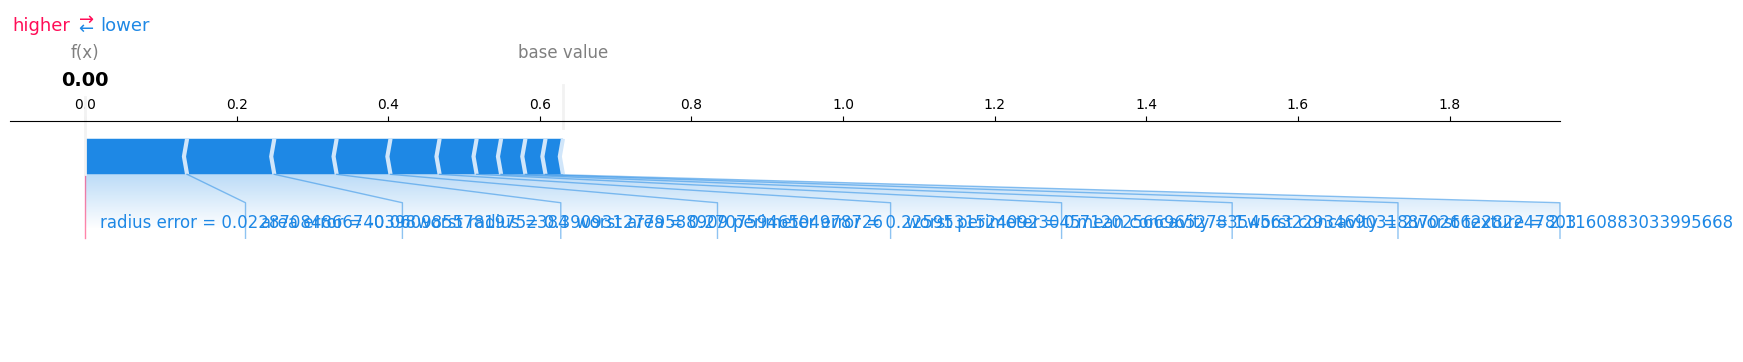

PermutationExplainer explainer: 496it [00:29, 15.97it/s]                                                               


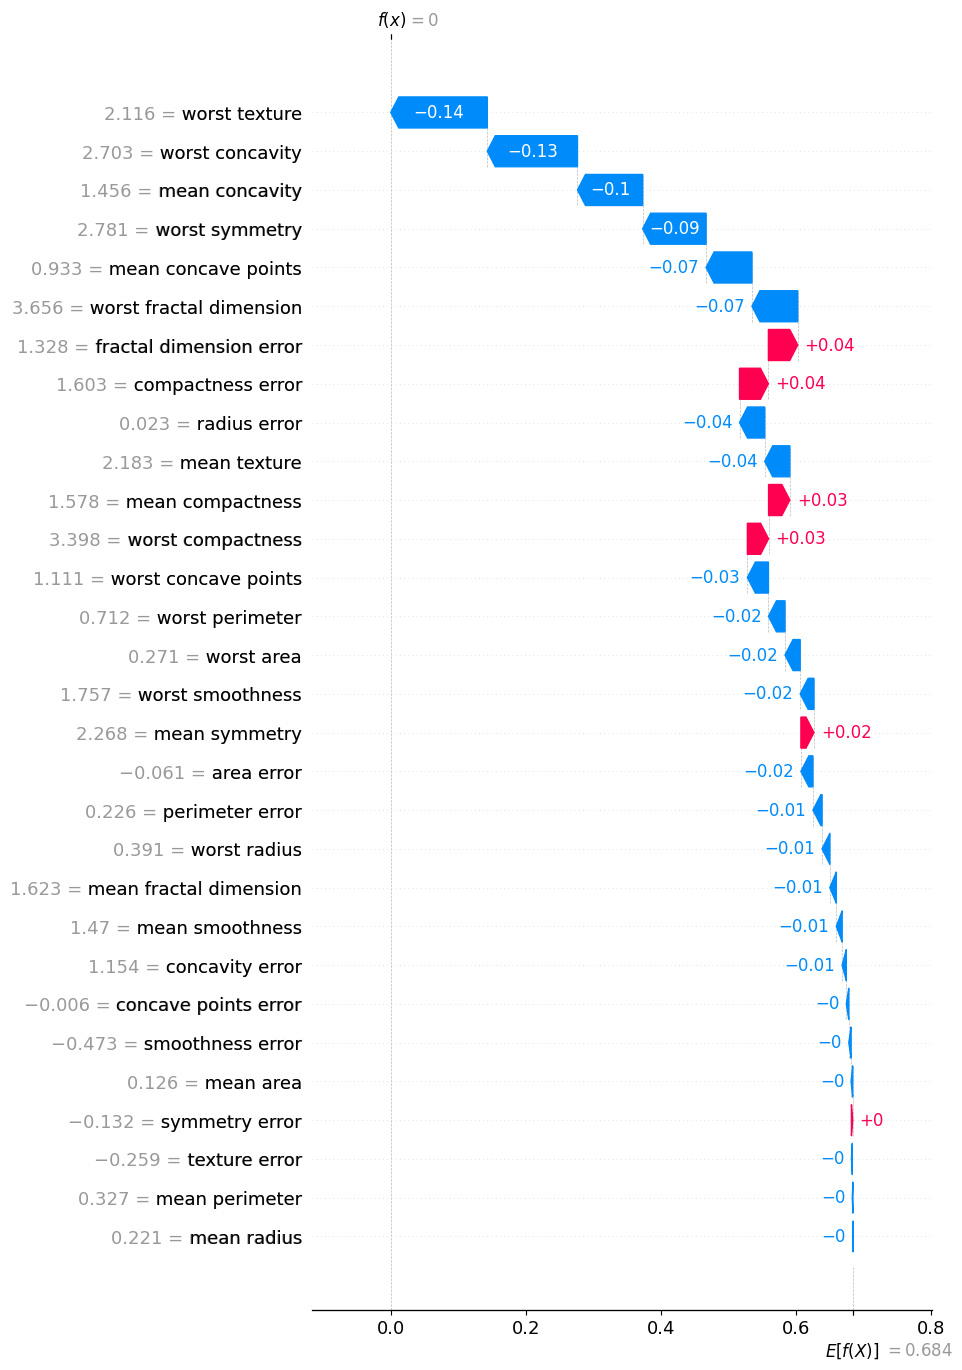

In [ ]:
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('Agg') # for save png but not plt.show()
# Choose one instance to explain
i = 10
shap.force_plot(
    explainer.expected_value[1],
    shap_values[:,:,1][i],
    X.iloc[i],
    feature_names=numerical_cols,
    matplotlib=True
)
plt.gcf().set_size_inches(10, 3)  # Optional: make it wider
#plt.savefig('./assets/breast_cancer_shap_force_plot.png', bbox_inches="tight")
#plt.close()

from shap import Explanation
#explainer2 = shap.Explainer(model, X) # show logit

# Wrap your model to output probabilities
def predict_proba_fn(X):
    return model.predict_proba(X)[:, 1]  # for binary classification

explainer2 = shap.Explainer(predict_proba_fn, X)
shap_values2 = explainer2(X)  # shap.Explanation object
shap.plots.waterfall(shap_values2[i], max_display=len(numerical_cols))
#plt.savefig('./assets/breast_cancer_shap_waterfall.png', bbox_inches="tight")
#plt.close()